<h1 style="color: blue;">Predictive Modelling and Risk Scoring for Diabetes Outcomes (Goals 2 and 3)</h1>

# Train–test split
To evaluate our models fairly, we split the data into a training set (used to fit the models) and a separate test set (used only for final evaluation). We use a stratified split based on the target variable so that the class proportions (diabetes vs no diabetes, or the different stages) are similar in both sets. All preprocessing and model fitting will be done on the training data only to avoid data leakage.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, 
)

import matplotlib.pyplot as plt

df_before = pd.read_csv("../data/diabetes_dataset.csv")


## Define targets and make leakage-safe

In [2]:
# columns we do not use as features (targets + leakage)
DIAG_COL  = "diagnosed_diabetes"
STAGE_COL = "diabetes_stage"
LEAK_COL  = "diabetes_risk_score"

# lab cols (removed to avoid leakage from downstream markers)
LAB_COLS = [
    "glucose_fasting",
    "glucose_postprandial",
    "hba1c",
    "insulin_level"
]

# filter out rare categories
RARE_STAGES = ["Type 1", "Gestational"]
df = df_before[~df_before[STAGE_COL].isin(RARE_STAGES)]

# split target
y_diag  = df[DIAG_COL]
y_stage = df[STAGE_COL]

# drop targets, leakage and lab cols if present
drop_cols = [c for c in [DIAG_COL, STAGE_COL, LEAK_COL] + LAB_COLS if c in df.columns]

X = df.drop(columns=drop_cols)

df_before.shape, df.shape, df[STAGE_COL].value_counts(), X.shape, len(drop_cols), drop_cols

((100000, 31),
 (99600, 31),
 diabetes_stage
 Type 2          59774
 Pre-Diabetes    31845
 No Diabetes      7981
 Name: count, dtype: int64,
 (99600, 24),
 7,
 ['diagnosed_diabetes',
  'diabetes_stage',
  'diabetes_risk_score',
  'glucose_fasting',
  'glucose_postprandial',
  'hba1c',
  'insulin_level'])

## Preprocessing (numeric, categorical)

In [3]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

len(num_cols), len(cat_cols)


(18, 6)

## Stratified split for diagnosis

In [4]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X, y_diag,
    test_size=0.2,
    random_state=42,
    stratify=y_diag
)

X_train_d.shape, X_test_d.shape, y_train_d.value_counts(normalize=True), y_test_d.value_counts(normalize=True)


((79680, 24),
 (19920, 24),
 diagnosed_diabetes
 1    0.600138
 0    0.399862
 Name: proportion, dtype: float64,
 diagnosed_diabetes
 1    0.600151
 0    0.399849
 Name: proportion, dtype: float64)

## Baseline Logistic Regression for diagnosis

ROC AUC: 0.6627


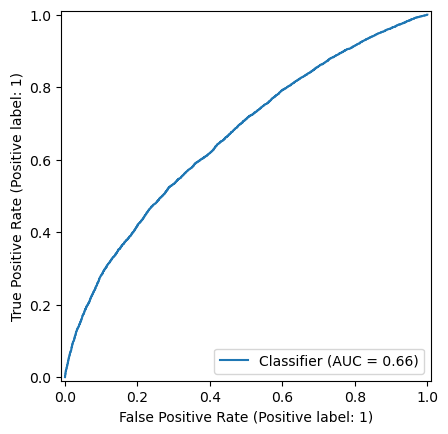

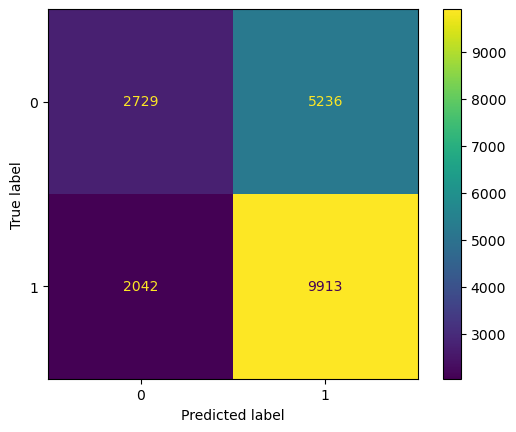

              precision    recall  f1-score   support

           0      0.572     0.343     0.429      7965
           1      0.654     0.829     0.731     11955

    accuracy                          0.635     19920
   macro avg      0.613     0.586     0.580     19920
weighted avg      0.621     0.635     0.610     19920



In [5]:
diag_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=3000,
        class_weight=None
    ))
])

diag_model.fit(X_train_d, y_train_d)

# Probabilities + ROC AUC
proba_test = diag_model.predict_proba(X_test_d)[:, 1]
auc = roc_auc_score(y_test_d, proba_test)
print("ROC AUC:", round(auc, 4))

RocCurveDisplay.from_predictions(y_test_d, proba_test)
plt.show()

# Default threshold 0.5 -> confusion matrix + report
pred_test = (proba_test >= 0.5).astype(int)

cm = confusion_matrix(y_test_d, pred_test)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.show()

print(classification_report(y_test_d, pred_test, digits=3))


### Result

The baseline logistic regression model for **diagnosed_diabetes** achieved a ROC AUC of **0.66**, indicating only moderate discrimination between patients with and without diabetes when using upstream risk factors alone. With the default 0.5 threshold, overall accuracy was **0.64**. The model showed **high recall for diabetics** (recall for class 1 ≈ **0.83**), meaning it correctly identifies most patients with diagnosed diabetes, but at the cost of **low recall for non-diabetics** (recall for class 0 ≈ **0.34**), i.e. many non-diabetic individuals are falsely flagged as diabetic. Precision for the positive class is reasonable (≈ **0.65**), so among those predicted as diabetic, around two-thirds actually have diagnosed diabetes. Overall, the model is tuned more towards **catching as many diabetics as possible**, while accepting a relatively high false-positive rate among those without diabetes.


## Initial multiclass modelling

### Stratified split

We split the data into training and test sets using a stratified split so that
the class distribution (No Diabetes / Pre-Diabetes / Type 2) remains similar in both
sets. This is important because the classes are imbalanced.

In [6]:
y_stage = df[STAGE_COL]
X_stage = df.drop(columns=drop_cols)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_stage, y_stage,
    test_size=0.2,
    random_state=42,
    stratify=y_stage
)

### Logistic regression

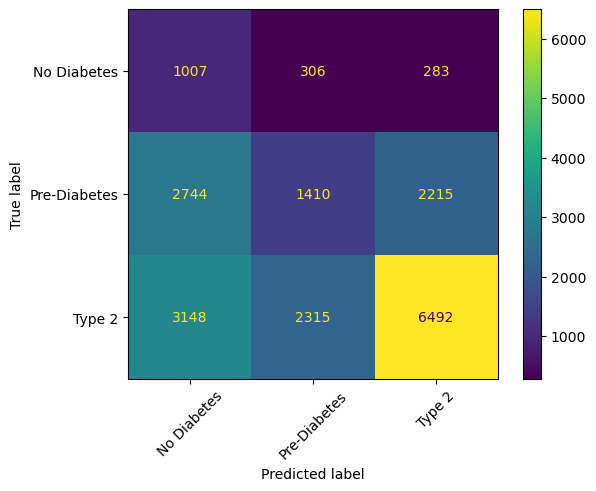

              precision    recall  f1-score   support

 No Diabetes      0.146     0.631     0.237      1596
Pre-Diabetes      0.350     0.221     0.271      6369
      Type 2      0.722     0.543     0.620     11955

    accuracy                          0.447     19920
   macro avg      0.406     0.465     0.376     19920
weighted avg      0.557     0.447     0.478     19920



In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

stage_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=5000,
        class_weight="balanced"
    ))
])

stage_lr.fit(X_train_s, y_train_s)
pred_s = stage_lr.predict(X_test_s)

labels = ["No Diabetes", "Pre-Diabetes", "Type 2"]

ConfusionMatrixDisplay.from_predictions(
    y_test_s, pred_s, labels=labels, xticks_rotation=45, values_format="d"
)
plt.show()

print(classification_report(y_test_s, pred_s, labels=labels, digits=3))



### Result

The logistic regression model showed clear differences in performance between the
three classes. **Type 2** was predicted most accurately, with a precision of ~0.72
and recall ~0.54. This reflects the fact that Type 2 is the most common class and
has clearer clinical signals (older age, higher lipids and blood pressure).

**No Diabetes** had high recall (~ 0.63), meaning that most non-diabetic cases were
identified correctly, but precision was very low (~ 0.15), so many patients were
incorrectly flagged as non-diabetic. **Pre-Diabetes** was the most difficult class:
recall was lowest (~ 0.22) and overall performance was weak.

Overall accuracy was ~ 0.45, driven by the class imbalance and the overlap between
Pre-Diabetes and both other groups. The model is better at separating **Type 2** from
the rest than distinguishing between **Pre-Diabetes** and **No Diabetes**, which is
expected given the similarity in upstream risk factors and the absence of laboratory
markers in the feature set.

## Random forest classifier

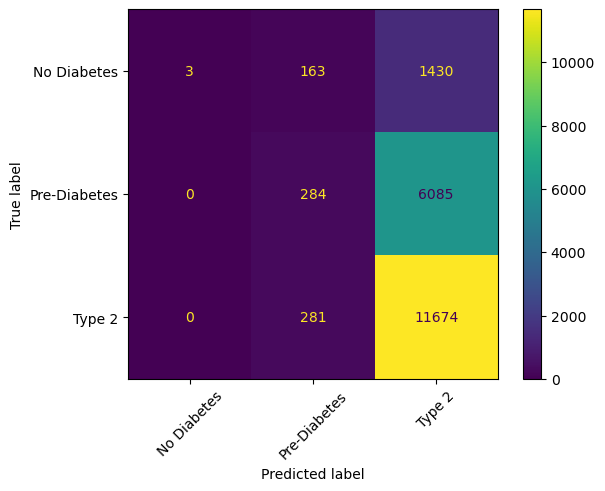

              precision    recall  f1-score   support

 No Diabetes      1.000     0.002     0.004      1596
Pre-Diabetes      0.390     0.045     0.080      6369
      Type 2      0.608     0.976     0.750     11955

    accuracy                          0.600     19920
   macro avg      0.666     0.341     0.278     19920
weighted avg      0.570     0.600     0.476     19920



In [8]:
from sklearn.ensemble import RandomForestClassifier

stage_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

stage_rf.fit(X_train_s, y_train_s)
pred_rf = stage_rf.predict(X_test_s)

ConfusionMatrixDisplay.from_predictions(
    y_test_s, pred_rf, labels=labels, xticks_rotation=45, values_format="d"
)
plt.show()

print(classification_report(y_test_s, pred_rf, labels=labels, digits=3))

### Result

The random forest model reached an overall accuracy of **0.60**, slightly higher than
logistic regression, but the performance is very uneven across classes.

- **Type 2** is predicted very aggressively: recall is extremely high (~0.98), meaning
  almost all Type 2 cases are correctly detected. However, precision is only ~0.61,
  so many patients from other stages are also classified as Type 2.

- **Pre-Diabetes** remains difficult to identify. Precision is modest (~ 0.39) and
  recall is very low (~ 0.05), indicating that most pre-diabetic patients are still
  misclassified, mainly as Type 2.

- **No Diabetes** has almost perfect precision (~ 1.00) but essentially zero recall
  (~ 0.002): the model predicts this class only for a handful of cases, and almost all
  true non-diabetic patients are labelled as having some form of diabetes.

Macro-averaged F1-score (~0.28) is low, showing that the model is heavily dominated
by the majority class (**Type 2**). In practice, the random forest prioritises
catching Type 2 diabetes at the cost of severely over-calling diabetes in people
with No Diabetes or Pre-Diabetes, and does not provide well-balanced stage
predictions.

## Linear SVM (LinearSVC)

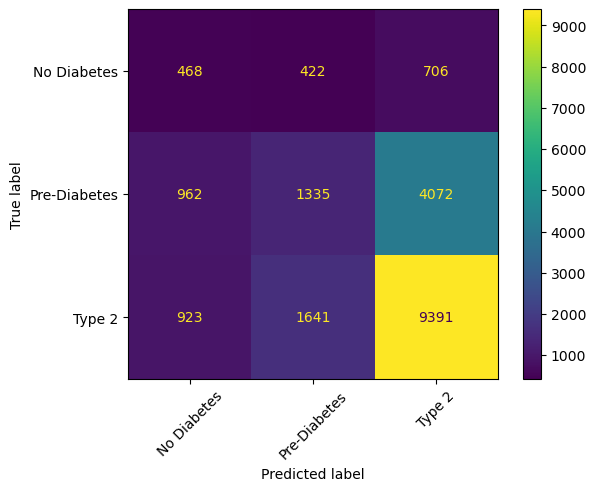

              precision    recall  f1-score   support

 No Diabetes      0.199     0.293     0.237      1596
Pre-Diabetes      0.393     0.210     0.273      6369
      Type 2      0.663     0.786     0.719     11955

    accuracy                          0.562     19920
   macro avg      0.418     0.429     0.410     19920
weighted avg      0.539     0.562     0.538     19920



In [9]:
from sklearn.svm import LinearSVC

stage_svm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearSVC(class_weight="balanced", random_state=42))
])

stage_svm.fit(X_train_s, y_train_s)
pred_svm = stage_svm.predict(X_test_s)

ConfusionMatrixDisplay.from_predictions(
    y_test_s, pred_svm, labels=labels, xticks_rotation=45, values_format="d"
)
plt.show()

print(classification_report(y_test_s, pred_svm, labels=labels, digits=3))


### Result

The Linear SVM achieved an overall accuracy of **0.56**, higher than logistic
regression (~ 0.45) and slightly lower than the random forest (~ 0.60). Performance
varied across classes:

- **Type 2** was predicted best, with precision ~0.66 and recall ~0.79. Most Type 2
  cases were correctly identified, although a substantial number of other patients
  were also labelled as Type 2.

- **Pre-Diabetes** remained difficult: recall was low (~ 0.21) and precision ~0.39.
  Many pre-diabetic patients were misclassified as Type 2, similar to previous models.

- **No Diabetes** improved compared to the random forest: recall increased from ~ 0.00
  to ~ 0.29, although precision was still low (~ 0.20). The model still struggles to
  correctly separate non-diabetic from the other stages.

Macro-averaged F1-score was ~0.41, showing that the model is moderately balanced 
overall, but performance is still dominated by the majority class (Type 2). In
summary, the SVM sits between logistic regression and random forest: it improves
over LR, but still cannot reliably distinguish Pre-Diabetes or No Diabetes in the
absence of laboratory markers.


# Multiclass modelling overall result

## Random forest – hyperparameter tuning (RandomizedSearchCV)

To improve the random forest stage model, we perform hyperparameter tuning using
`RandomizedSearchCV`. This randomly samples combinations of hyperparameters from a
predefined search space, which is more efficient than an exhaustive grid search for
a model with many possible settings.

We tune the number of trees, maximum depth, minimum number of samples per leaf and
the feature sampling strategy, using stratified 3-fold cross-validation and
macro-averaged F1 as the optimisation metric. After selecting the best configuration,
we refit the model on the full training set and evaluate it on the held-out test set,
allowing a fair comparison with the baseline models.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
import numpy as np

# 0) Teeme korra preprocessing'u ära, et saada numbriline X
X_train_enc = preprocess.fit_transform(X_train_d)
X_test_enc  = preprocess.transform(X_test_d)

# 1) Väike alamvalim tuunimiseks (kiirem)
n_sub = min(20000, X_train_enc.shape[0])

X_tune, _, y_tune, _ = train_test_split(
    X_train_enc, y_train_d,
    train_size=n_sub,
    stratify=y_train_d,
    random_state=42
)

print("Tuning subsample:", X_tune.shape)

# 2) Random Forest + hüperparameetrite ruum (veidi kokku tõmmatud)
param_dist = {
    "n_estimators": [200, 300],        # mitte 4–5 varianti
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True],              # keep it simple
}

rf = RandomForestClassifier(
    random_state=1,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=4,              
    scoring="f1_macro", 
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=1
)

search.fit(X_tune, y_tune)
best_rf = search.best_estimator_

print("Best params:", search.best_params_)
print("Best CV macro-F1 (subsample):", round(search.best_score_, 3))

best_rf.fit(X_train_enc, y_train_d)

y_pred = best_rf.predict(X_test_enc)
print(classification_report(y_test_d, y_pred, digits=3))


Tuning subsample: (20000, 42)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best CV macro-F1 (subsample): 0.603
              precision    recall  f1-score   support

           0      0.505     0.651     0.569      7965
           1      0.712     0.575     0.636     11955

    accuracy                          0.605     19920
   macro avg      0.608     0.613     0.602     19920
weighted avg      0.629     0.605     0.609     19920



## Gradient Boosting

Subsample for GB tuning: (20000, 42)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
GB best params (subsample): {'subsample': 1.0, 'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 2, 'learning_rate': 0.2}
GB best CV macro-F1 (subsample): 0.57
              precision    recall  f1-score   support

           0      0.571     0.337     0.424      7965
           1      0.653     0.831     0.731     11955

    accuracy                          0.634     19920
   macro avg      0.612     0.584     0.578     19920
weighted avg      0.620     0.634     0.609     19920



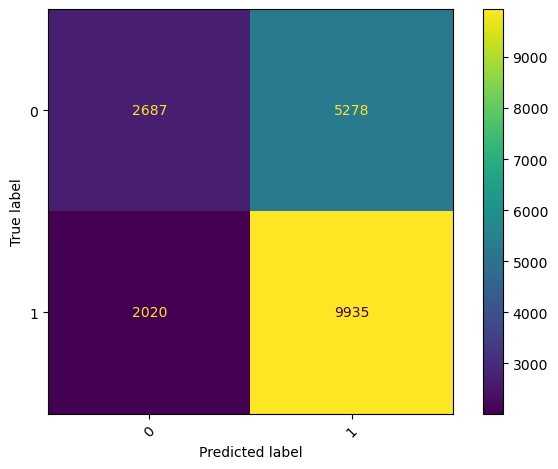

In [11]:
print("Subsample for GB tuning:", X_tune.shape)

gb = GradientBoostingClassifier(random_state=1)

param_dist_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3],
    "min_samples_leaf": [1, 5, 10],
    "subsample": [0.7, 1.0],
}

gb_search = RandomizedSearchCV(
    gb,
    param_distributions=param_dist_gb,
    n_iter=5,            # väike, et oleks kiire
    scoring="f1_macro",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=1,
)

gb_search.fit(X_tune, y_tune)

print("GB best params (subsample):", gb_search.best_params_)
print("GB best CV macro-F1 (subsample):", round(gb_search.best_score_, 3))

best_gb = gb_search.best_estimator_

best_gb.fit(X_train_enc, y_train_d)

y_pred_gb = best_gb.predict(X_test_enc)

print(classification_report(y_test_d, y_pred_gb, digits=3))

labels = np.unique(y_test_d)
ConfusionMatrixDisplay.from_predictions(
    y_test_d, y_pred_gb,
    labels=labels,
    xticks_rotation=45,
    values_format="d"
)
plt.tight_layout()
plt.show()


In [12]:
X_train_enc = preprocess.fit_transform(X_train_d)
X_test_enc  = preprocess.transform(X_test_d)

n_sub = min(40000, X_train_enc.shape[0])

X_tune, _, y_tune, _ = train_test_split(
    X_train_enc, y_train_d,
    train_size=n_sub,
    stratify=y_train_d,
    random_state=42
)

print("Tuning subsample:", X_tune.shape)

param_dist = {
    "n_estimators": [300, 500, 800], 
    "max_depth": [None, 12, 20, 40],  
    "max_features": ["sqrt", "log2", 0.3],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True],
}

rf = RandomForestClassifier(
    random_state=1,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,          
    scoring="f1_macro",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=1
)

search.fit(X_tune, y_tune)
best_rf = search.best_estimator_

print("Best params:", search.best_params_)
print("Best CV macro-F1 (subsample):", round(search.best_score_, 3))

best_rf.fit(X_train_enc, y_train_d)

y_pred = best_rf.predict(X_test_enc)
print(classification_report(y_test_d, y_pred, digits=3))


Tuning subsample: (40000, 42)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': 12, 'bootstrap': True}
Best CV macro-F1 (subsample): 0.602
              precision    recall  f1-score   support

           0      0.509     0.627     0.562      7965
           1      0.706     0.597     0.647     11955

    accuracy                          0.609     19920
   macro avg      0.608     0.612     0.604     19920
weighted avg      0.627     0.609     0.613     19920



## ROC curve comparison

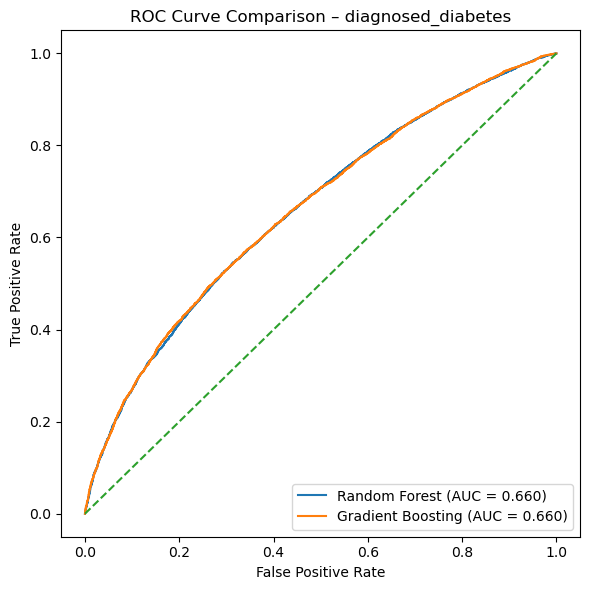

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

models = {
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb,
}

plt.figure(figsize=(6, 6))


for name, model in models.items():
    y_score = model.predict_proba(X_test_enc)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_d, y_score)
    auc = roc_auc_score(y_test_d, y_score)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")


plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison – diagnosed_diabetes")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


We compared the ROC curves of the tuned Random Forest and Gradient Boosting models on the test set. Both models achieved an identical AUC of 0.66, indicating that they have very similar ability to rank individuals by their diabetes risk. However, their behaviour at a fixed decision threshold (0.5) differed substantially. Gradient Boosting strongly favoured the positive class, reaching a recall of 0.83 for diabetes but only 0.34 for the non-diabetes class. In contrast, the tuned Random Forest achieved a much more balanced performance, with recalls of 0.60–0.63 for both classes and the highest macro-F1 score (0.60) among all tested models.
Because our goal is to detect diabetes cases without generating an excessive number of false alarms, we chose the Random Forest as the final model. The ROC analysis confirms that this choice does not sacrifice overall ranking performance, as both models share the same AUC.

## Result analysis

In [14]:
models = {
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb,

rows = []

for name, model in models.items():
    y_pred = model.predict(X_test_enc)
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_enc)[:, 1]
    else:
        y_score = model.decision_function(X_test_enc)
    
    tn, fp, fn, tp = confusion_matrix(y_test_d, y_pred).ravel()
    
    acc = accuracy_score(y_test_d, y_pred)
    macro_f1 = f1_score(y_test_d, y_pred, average="macro")
    auc = roc_auc_score(y_test_d, y_score)
    
    rows.append({
        "Model": name,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "TP": tp,
        "Accuracy": acc,
        "Macro-F1": macro_f1,
        "ROC-AUC": auc,
    })

df_models = pd.DataFrame(rows).set_index("Model")
df_models = df_models.sort_values(by="ROC-AUC", ascending=False)

print(df_models.round(3))


SyntaxError: '{' was never closed (2277454050.py, line 5)

In [ ]:
x = range(len(df_models))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    [i - bar_width/2 for i in x],
    df_models["FP"],
    width=bar_width,
    label="False Positives",
    color="salmon"
)

ax.bar(
    [i + bar_width/2 for i in x],
    df_models["FN"],
    width=bar_width,
    label="False Negatives",
    color="skyblue"
)

for i in x:
    ax.text(
        i - bar_width/2,
        df_models["FP"].iloc[i] + 1,
        str(df_models["FP"].iloc[i]),
        ha='center',
        va='bottom',
        fontsize=9
    )
    ax.text(
        i + bar_width/2,
        df_models["FN"].iloc[i] + 1,
        str(df_models["FN"].iloc[i]),
        ha='center',
        va='bottom',
        fontsize=9
    )

ax.set_xticks(x)
ax.set_xticklabels(df_models.index, rotation=45, ha='right')
ax.set_ylabel("Count")
ax.set_title("False Positives and False Negatives by Model")
ax.legend()

plt.tight_layout()
plt.show()


Among all trained models, we selected the tuned Random Forest classifier as our final model for predicting diagnosed_diabetes. Although Gradient Boosting achieved a slightly higher accuracy (0.634 vs. 0.609), it did so by strongly favouring the positive class: its recall for diabetes was very high (0.831), but the recall for the non-diabetes class dropped to only 0.337. This behaviour implies a substantial number of false positives, i.e. many healthy individuals would be incorrectly classified as diabetic.

In contrast, the tuned Random Forest provided a much more balanced performance across classes. It achieved the highest macro-F1 score among all models (0.604), indicating better overall discrimination between both classes. Recall for the diabetes class was 0.597 and for the non-diabetes class 0.627, making the model considerably more suitable when both outcomes are clinically meaningful. Since our goal is to identify diabetes while avoiding excessive false alarms, the Random Forest represents the best compromise between sensitivity and specificity.

# Goal 3: key predictors, score

## Feature importance

In [ ]:
num_cols = preprocess.transformers_[0][2]   # ("num", pipeline, num_cols)
cat_cols = preprocess.transformers_[1][2]   # ("cat", pipeline, cat_cols)

cat_transformer = preprocess.named_transformers_["cat"]

ohe = cat_transformer.named_steps.get("onehot") or cat_transformer.named_steps.get("encoder")

cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, cat_feature_names])

rf_importances = (
    pd.Series(best_rf.feature_importances_, index=feature_names)
      .sort_values(ascending=False)
)

# top 20
rf_importances.head(20)


## Correlation

In [ ]:
X_train_enc_df = pd.DataFrame(X_train_enc, columns=feature_names)

corr_df = X_train_enc_df.copy()
corr_df["diagnosed_diabetes"] = y_train_d.values

corr_series = corr_df.corr()["diagnosed_diabetes"].drop("diagnosed_diabetes")

# top 20
top_feats = rf_importances.head(20).index
corr_top = corr_series.loc[top_feats].sort_values(ascending=False)

corr_top_df = pd.DataFrame({
    "importance": rf_importances.loc[top_feats],
    "corr_with_diabetes": corr_top
}).sort_values(by="importance", ascending=False)

corr_top_df


In [ ]:
corr_top_sorted = corr_top_df.sort_values("importance", ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(corr_top_sorted.index, corr_top_sorted["importance"])
ax.set_xlabel("Random Forest feature importance")
ax.set_title("Top predictors for diagnosed_diabetes (RF importance)")
plt.tight_layout()
plt.show()

corr_sorted = corr_top_df.sort_values("corr_with_diabetes", ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(corr_sorted.index, corr_sorted["corr_with_diabetes"])
ax.set_xlabel("Pearson correlation with diagnosed_diabetes")
ax.set_title("Direction of association for RF top predictors")
plt.tight_layout()
plt.show()


### Results

The tuned Random Forest model highlighted several clinically meaningful predictors of diagnosed diabetes. The most influential features were family history of diabetes, age, physical activity, and BMI, followed by blood pressure and lipid-related measures. These variables are consistent with established epidemiological evidence and therefore increase confidence in the model’s face validity.

To investigate the direction of association, we calculated Pearson correlations between each top feature and the binary diabetes outcome. This revealed a clear pattern:

Positive associations (higher value → greater diabetes risk):

family history of diabetes

age

BMI

systolic blood pressure

waist-to-hip ratio

LDL cholesterol and triglycerides

These associations reflect well-known cardiometabolic risk factors.

Negative associations (higher value → lower risk):

physical activity minutes per week

dietary score

HDL cholesterol

These features are consistent with protective behaviours and healthier lipid profiles.

Although correlation strengths were modest (as expected for individual predictors in a multifactorial condition), the results matched the feature importance rankings from the Random Forest. This convergence indicates that the model is picking up clinically interpretable signals rather than spurious patterns.

## Point-based risk score

In [15]:
def score_age(age):
    if pd.isna(age):
        return 1
    if age < 40:
        return 0
    elif age < 55:
        return 1
    elif age < 65:
        return 2
    else:
        return 3

def score_bmi(bmi):
    if pd.isna(bmi):
        return 1
    if bmi < 25:
        return 0
    elif bmi < 30:
        return 1
    elif bmi < 35:
        return 2
    else:
        return 3

def score_sbp(sbp):
    if pd.isna(sbp):
        return 1
    if sbp < 120:
        return 0
    elif sbp < 140:
        return 1
    elif sbp < 160:
        return 2
    else:
        return 3

def score_activity(minutes):
    # more minutes → lower risk
    if pd.isna(minutes):
        return 2
    if minutes >= 150:
        return 0
    elif minutes >= 60:
        return 1
    elif minutes > 0:
        return 2
    else:  # 0 minutes
        return 3

def score_family_history(x):
    if x in [1, "Yes", "Y", True]:
        return 3
    else:
        return 0

df["our_risk_score"] = (
    df["age"].apply(score_age)
    + df["bmi"].apply(score_bmi)
    + df["systolic_bp"].apply(score_sbp)
    + df["physical_activity_minutes_per_week"].apply(score_activity)
    + df["family_history_diabetes"].apply(score_family_history)
)

df["our_risk_score"].describe()


C:\Users\sofiaapr\AppData\Local\Temp\ipykernel_10252\972890508.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["our_risk_score"] = (


count    99600.000000
mean         4.107510
std          2.210248
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         13.000000
Name: our_risk_score, dtype: float64

## Low/Medium/High risk groups

In [16]:
df_train = df.loc[X_train_d.index].copy()
df_test  = df.loc[X_test_d.index].copy()

# quantiles from training set only
q_low, q_high = df_train["our_risk_score"].quantile([0.33, 0.66])

def map_our_group(score, q_low, q_high):
    if score <= q_low:
        return "Low"
    elif score <= q_high:
        return "Medium"
    else:
        return "High"

df_train["our_risk_group"] = df_train["our_risk_score"].apply(map_our_group, args=(q_low, q_high))
df_test["our_risk_group"]  = df_test["our_risk_score"].apply(map_our_group, args=(q_low, q_high))


## dataset score

In [17]:
q_low_b, q_high_b = df_train["diabetes_risk_score"].quantile([0.33, 0.66])

def map_baseline_group(score, q_low, q_high):
    if score <= q_low:
        return "Low"
    elif score <= q_high:
        return "Medium"
    else:
        return "High"

df_train["baseline_risk_group"] = df_train["diabetes_risk_score"].apply(map_baseline_group, args=(q_low_b, q_high_b))
df_test["baseline_risk_group"]  = df_test["diabetes_risk_score"].apply(map_baseline_group, args=(q_low_b, q_high_b))


## Comparison

In [18]:
# Our score
tab_ours = pd.crosstab(
    df_test["our_risk_group"],
    df_test["diagnosed_diabetes"],
    normalize="index"
).round(3)

# Baseline score
tab_base = pd.crosstab(
    df_test["baseline_risk_group"],
    df_test["diagnosed_diabetes"],
    normalize="index"
).round(3)

print("Our score: P(diabetes | group)")
print(tab_ours)
print("\nBaseline diabetes_risk_score: P(diabetes | group)")
print(tab_base)


Our score: P(diabetes | group)
diagnosed_diabetes      0      1
our_risk_group                  
High                0.237  0.763
Low                 0.515  0.485
Medium              0.375  0.625

Baseline diabetes_risk_score: P(diabetes | group)
diagnosed_diabetes       0      1
baseline_risk_group              
High                 0.246  0.754
Low                  0.546  0.454
Medium               0.417  0.583


In [19]:
auc_ours = roc_auc_score(df_test["diagnosed_diabetes"], df_test["our_risk_score"])
auc_base = roc_auc_score(df_test["diagnosed_diabetes"], df_test["diabetes_risk_score"])

print("Our risk score ROC AUC:", round(auc_ours, 3))
print("Baseline diabetes_risk_score ROC AUC:", round(auc_base, 3))


Our risk score ROC AUC: 0.646
Baseline diabetes_risk_score ROC AUC: 0.663


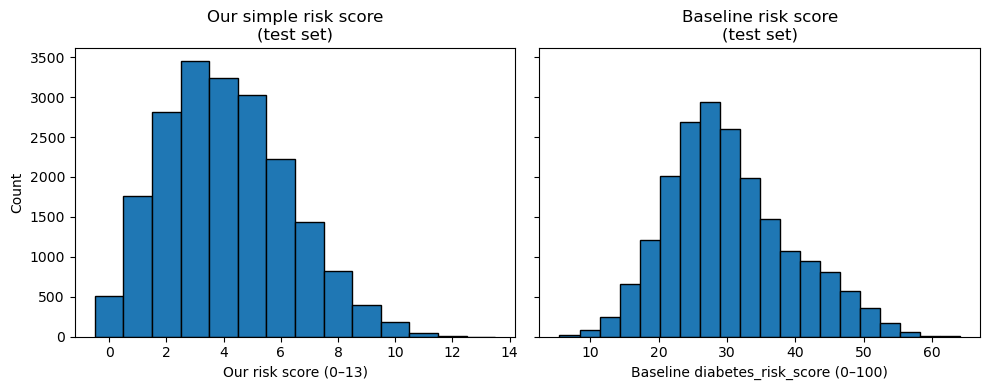

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].hist(
    df_test["our_risk_score"],
    bins=range(0, 15),
    edgecolor="black",
    align="left"
)
axes[0].set_xlabel("Our risk score (0–13)")
axes[0].set_ylabel("Count")
axes[0].set_title("Our simple risk score\n(test set)")

axes[1].hist(
    df_test["diabetes_risk_score"],
    bins=20,
    edgecolor="black"
)
axes[1].set_xlabel("Baseline diabetes_risk_score (0–100)")
axes[1].set_title("Baseline risk score\n(test set)")

plt.tight_layout()
plt.show()


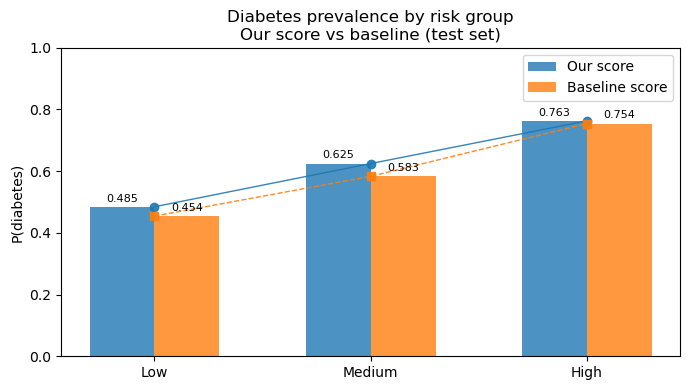

In [21]:

# prevalence
prev_ours = (
    df_test.groupby("our_risk_group")["diagnosed_diabetes"]
    .mean()
    .reindex(["Low", "Medium", "High"])
)

prev_base = (
    df_test.groupby("baseline_risk_group")["diagnosed_diabetes"]
    .mean()
    .reindex(["Low", "Medium", "High"])
)

prev_df = pd.DataFrame({
    "Our score": prev_ours,
    "Baseline score": prev_base
})

fig, ax = plt.subplots(figsize=(7,4))

x = np.arange(len(prev_df.index))
ax.bar(x - 0.15, prev_df["Our score"], width=0.3, alpha=0.8, label="Our score")
ax.bar(x + 0.15, prev_df["Baseline score"], width=0.3, alpha=0.8, label="Baseline score")

ax.plot(x, prev_df["Our score"], marker="o", linestyle="-", linewidth=1, alpha=0.9)
ax.plot(x, prev_df["Baseline score"], marker="s", linestyle="--", linewidth=1, alpha=0.9)

for i, (v1, v2) in enumerate(zip(prev_df["Our score"], prev_df["Baseline score"])):
    ax.text(x[i] - 0.15, v1 + 0.01, f"{v1:.3f}", ha="center", va="bottom", fontsize=8)
    ax.text(x[i] + 0.15, v2 + 0.01, f"{v2:.3f}", ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(prev_df.index)
ax.set_ylim(0,1)
ax.set_ylabel("P(diabetes)")
ax.set_title("Diabetes prevalence by risk group\nOur score vs baseline (test set)")
ax.legend()
plt.tight_layout()
plt.show()


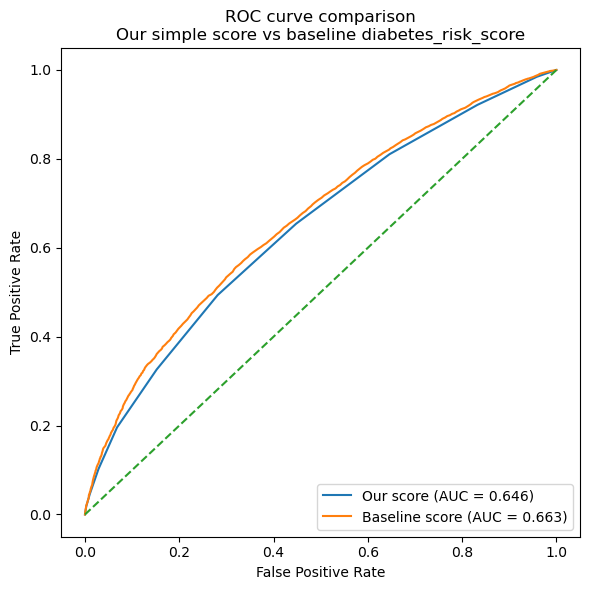

In [22]:
y_true = df_test["diagnosed_diabetes"].values

our_score = df_test["our_risk_score"].values
base_score = df_test["diabetes_risk_score"].values

fpr_our, tpr_our, _ = roc_curve(y_true, our_score)
fpr_base, tpr_base, _ = roc_curve(y_true, base_score)

auc_our  = roc_auc_score(y_true, our_score)
auc_base = roc_auc_score(y_true, base_score)

plt.figure(figsize=(6,6))
plt.plot(fpr_our,  tpr_our,  label=f"Our score (AUC = {auc_our:.3f})")
plt.plot(fpr_base, tpr_base, label=f"Baseline score (AUC = {auc_base:.3f})")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve comparison\nOur simple score vs baseline diabetes_risk_score")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


## Result

Using the most influential predictors from the tuned Random Forest (family history of diabetes, age, BMI, systolic blood pressure and physical activity minutes per week), we constructed a simple point-based risk score ranging from 0 to 13. The score was approximately bell-shaped in the test set, with a median of 4 points (IQR 2–6), indicating reasonable spread across patients. In contrast, the dataset’s pre-computed diabetes_risk_score ranged from 0 to 100 and showed a smooth unimodal distribution, consistent with a more complex continuous index combining many lifestyle and clinical variables.

To make the two scores comparable, we defined low, medium and high risk groups using training-set terciles and then evaluated diabetes prevalence in the held-out test set. For our simple score, the proportion of diagnosed diabetes increased monotonically from 48.5% in the low-risk group to 62.5% in the medium-risk group and 76.3% in the high-risk group. The pre-computed diabetes_risk_score showed a very similar gradient, with 45.4%, 58.3% and 75.4% diabetes in the low, medium and high groups, respectively. Thus, both scores stratify patients into groups with clearly increasing diabetes risk.

We also compared the scores in terms of overall discriminative performance using ROC curves. Our 5-variable score achieved a ROC AUC of 0.646, while the dataset’s diabetes_risk_score reached 0.663. This indicates that the built-in score performs slightly better in ranking individuals by diabetes risk, which is expected given that it likely incorporates a larger set of predictors. However, the performance gap is modest, and our simple score achieves very similar risk separation while remaining highly interpretable and easy to compute from a small number of routinely available variables.